In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
import sys
import os
import MetaTrader5 as mt5
from typing import Dict, List, Optional, Tuple

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale=1.2)

# Add project directory to path if needed
# sys.path.append('../')

# Import your project modules
try:
    from utils.data_utils import fetch_historical_data, TIMEFRAME_MAP
    from utils.indicator_utils import calculate_bollinger_bands
    from strategies import get_strategy
    from strategies.bollong import BollongStrategy
    from config import logger
except ImportError as e:
    print(f"Could not import project modules: {e}")
    print("Make sure you're running this notebook from the project root directory.")

# 1. MT5 INSTRUMENT ANALYSIS
# =========================

def connect_to_mt5() -> bool:
    """Connect to MetaTrader 5"""
    if not mt5.initialize():
        print(f"MT5 initialization failed, error code: {mt5.last_error()}")
        return False

    print(f"Successfully connected to MT5!")
    account_info = mt5.account_info()
    if account_info:
        print(f"Account: {account_info.login} ({account_info.company})")
        print(f"Balance: {account_info.balance} {account_info.currency}")
    return True

def get_instruments_info(symbols: Optional[List[str]] = None) -> pd.DataFrame:
    """Get detailed information about available trading instruments"""
    if not symbols:
        # Get all symbols available in Market Watch
        symbols_info = mt5.symbols_get()
        symbols = [s.name for s in symbols_info]
    else:
        # Ensure all symbols are available in Market Watch
        for symbol in symbols:
            if not mt5.symbol_select(symbol, True):
                print(f"Failed to select {symbol}")

    data = []
    for symbol in symbols:
        symbol_info = mt5.symbol_info(symbol)
        if symbol_info is None:
            print(f"Failed to get info for {symbol}")
            continue

        # Extract trading hours
        mon = getattr(symbol_info, 'session_deals_monday', [])
        tue = getattr(symbol_info, 'session_deals_tuesday', [])
        wed = getattr(symbol_info, 'session_deals_wednesday', [])
        thu = getattr(symbol_info, 'session_deals_thursday', [])
        fri = getattr(symbol_info, 'session_deals_friday', [])

        # Format trading hours
        trading_hours = {}
        for day, hours in zip(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], [mon, tue, wed, thu, fri]):
            if hours:
                trading_hours[day] = f"{hours[0][0]}:00 - {hours[0][1]}:00"
            else:
                trading_hours[day] = "Closed"

        # Get current spread
        tick = mt5.symbol_info_tick(symbol)
        current_spread = (tick.ask - tick.bid) / symbol_info.point if tick else None

        # Calculate pip value
        contract_size = symbol_info.trade_contract_size
        pip_value = symbol_info.point * contract_size

        data.append({
            'Symbol': symbol_info.name,
            'Description': symbol_info.description,
            'Base Currency': getattr(symbol_info, 'currency_base', ""),
            'Profit Currency': getattr(symbol_info, 'currency_profit', ""),
            'Digits': symbol_info.digits,
            'Point': symbol_info.point,
            'Contract Size': contract_size,
            'Pip Value': pip_value,
            'Min Lot': symbol_info.volume_min,
            'Max Lot': symbol_info.volume_max,
            'Lot Step': symbol_info.volume_step,
            'Current Spread (points)': current_spread,
            'Trading Hours': trading_hours,
            'Trade Mode': symbol_info.trade_mode,
            'Swap Long': symbol_info.swap_long,
            'Swap Short': symbol_info.swap_short,
            'Trade Allowed': symbol_info.trade_mode != 0,
        })

    return pd.DataFrame(data)

def visualize_spreads(instruments_df: pd.DataFrame, top_n: int = 20):
    """Visualize spreads for top_n instruments"""
    if 'Current Spread (points)' not in instruments_df.columns:
        print("Spread data not available")
        return

    # Filter out instruments with missing spread data
    spread_df = instruments_df.dropna(subset=['Current Spread (points)'])

    # Sort by spread
    spread_df = spread_df.sort_values('Current Spread (points)').head(top_n)

    # Create plot
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(spread_df)))

    bars = plt.barh(spread_df['Symbol'], spread_df['Current Spread (points)'], color=colors)
    plt.xlabel('Spread (points)')
    plt.ylabel('Symbol')
    plt.title(f'Spreads for Top {top_n} Instruments')
    plt.tight_layout()
    plt.show()

Strategie 'BollongStrategy' geregistreerd
Strategie 'OrderBlockLSTMStrategy' geregistreerd


In [3]:
# 2. HISTORICAL DATA ANALYSIS
# ==========================

def analyze_instrument(symbol: str, timeframe: str = "D1", days: int = 90):
    """Analyze historical data for a specific instrument"""
    print(f"Fetching data for {symbol} over the last {days} days (timeframe: {timeframe})")

    # Fetch historical data - use the correct parameters according to the function signature
    historical_data = fetch_historical_data(
        symbol=symbol,         # Corrected from 'instrument' to 'symbol'
        timeframe=timeframe,
        days=days              # Using 'days' instead of start_date/end_date
    )

    if historical_data is None or historical_data.empty:
        print(f"No data received for {symbol}")
        return None

    print(f"Successfully retrieved {len(historical_data)} data points")
    print("\nFirst 5 rows of data:")
    display(historical_data.head())

    # Create visualizations
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # 1. Price Chart with Bollinger Bands
    upper_band, sma, lower_band = calculate_bollinger_bands(
        historical_data['close'], window=20, std_dev=2.0
    )

    axes[0].plot(historical_data.index, historical_data['close'], label='Close Price', color='blue')
    axes[0].plot(historical_data.index, upper_band, label='Upper Band', color='red', linestyle='--')
    axes[0].plot(historical_data.index, sma, label='SMA', color='green', linestyle='-')
    axes[0].plot(historical_data.index, lower_band, label='Lower Band', color='red', linestyle='--')
    axes[0].fill_between(historical_data.index, upper_band, lower_band, alpha=0.1, color='gray')
    axes[0].set_title(f'{symbol} Price History with Bollinger Bands', fontsize=16)
    axes[0].set_ylabel('Price', fontsize=12)
    axes[0].legend()
    axes[0].grid(True)

    # 2. Volume chart (if available)
    if 'volume' in historical_data.columns:
        axes[1].bar(historical_data.index, historical_data['volume'], color='green', alpha=0.7)
        axes[1].set_title(f'{symbol} Trading Volume', fontsize=16)
        axes[1].set_ylabel('Volume', fontsize=12)
        axes[1].grid(True)

    # 3. Daily returns
    historical_data['daily_return'] = historical_data['close'].pct_change() * 100
    axes[2].plot(historical_data.index, historical_data['daily_return'], color='purple')
    axes[2].axhline(y=0, color='black', linestyle='--')
    axes[2].set_title(f'{symbol} Daily Returns (%)', fontsize=16)
    axes[2].set_ylabel('Return (%)', fontsize=12)
    axes[2].set_xlabel('Date', fontsize=12)
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # Distribution of returns
    plt.figure(figsize=(10, 6))
    plt.hist(historical_data['daily_return'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Daily Returns for {symbol}', fontsize=16)
    plt.xlabel('Daily Return (%)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    return historical_data


Successfully connected to MT5!
Account: 1520533067 (FTMO Global Markets Ltd)
Balance: 79102.58 EUR
Failed to select BRENT.CMD
Failed to get info for BRENT.CMD


,Symbol,Description,Base Currency,Profit Currency,Digits,Point,Contract Size,Pip Value,Min Lot,Max Lot,Lot Step,Current Spread (points),Trading Hours,Trade Mode,Swap Long,Swap Short,Trade Allowed
0,EURUSD,Euro vs United States Dollar,EUR,USD,5,0.00001,100000.0,1.00,0.01,50.0,0.01,3.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': 'Clo...",4,-10.36,2.99,True
1,GBPUSD,Great Britain Pound vs US Dollar,GBP,USD,5,0.00001,100000.0,1.00,0.01,50.0,0.01,8.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': 'Clo...",4,-1.15,-2.30,True
2,USDJPY,US Dollar vs Japanese Yen,USD,JPY,3,0.00100,100000.0,100.00,0.01,50.0,0.01,0.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': 'Clo...",4,0.04,-21.61,True
3,AUDUSD,Australian Dollar vs US Dollar,AUD,USD,5,0.00001,100000.0,1.00,0.01,50.0,0.01,0.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': 'Clo...",4,-2.15,-1.15,True
4,USDCAD,US Dollar vs Canadian Dollar,USD,CAD,5,0.00001,100000.0,1.00,0.01,50.0,0.01,0.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': 'Clo...",4,3.63,-12.28,True
5,XAUUSD,"Gold vs US Dollar, Spot CFD",USD,USD,2,0.01000,100.0,1.00,0.01,100.0,0.01,26.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': 'Clo...",4,-58.05,2.15,True
6,XAGUSD,"Silver vs US Dollar, Spot CFD",USD,USD,3,0.00100,5000.0,5.00,0.01,100.0,0.01,0.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': 'Clo...",4,-4.79,0.74,True
7,GER40.cash,"German 40 Index, Spot CFD",EUR,EUR,2,0.01000,1.0,0.01,0.01,1000.0,0.01,149.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': 'Clo...",4,-254.71,-0.29,True
8,US500.cash,"S&P 500 Index, Spot CFD",USD,USD,2,0.01000,1.0,0.01,0.01,1000.0,0.01,0.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': 'Clo...",4,-99.82,2.88,True


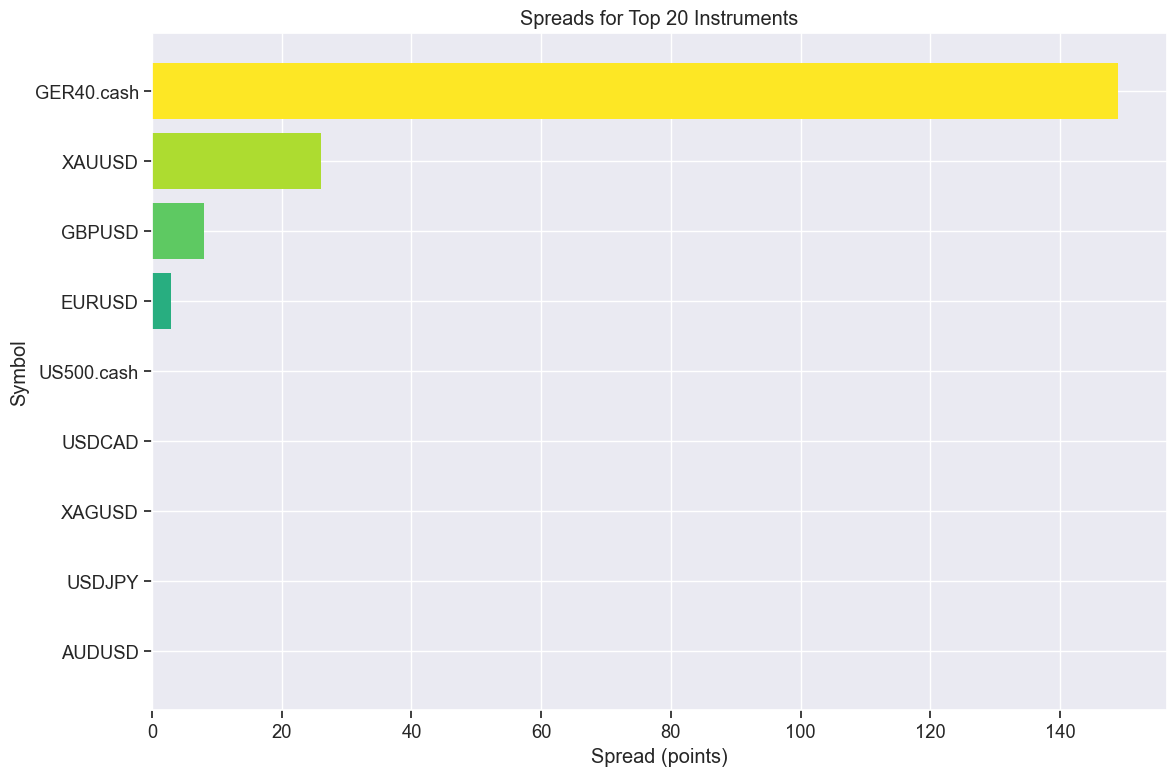

Fetching data for GER40.cash over the last 90 days (timeframe: D1)
Successfully retrieved 62 data points

First 5 rows of data:


,open,high,low,close,tick_volume,spread,real_volume
datetime,,,,,,,
2025-01-23,21244.23,21495.83,21220.53,21470.14,22421,135,0
2025-01-24,21471.73,21527.63,21348.33,21355.73,22164,135,0
2025-01-27,21293.33,21410.24,21078.93,21399.24,58858,135,0
2025-01-28,21399.73,21515.03,21297.13,21475.24,42624,135,0
2025-01-29,21470.83,21673.53,21466.83,21667.34,39218,135,0


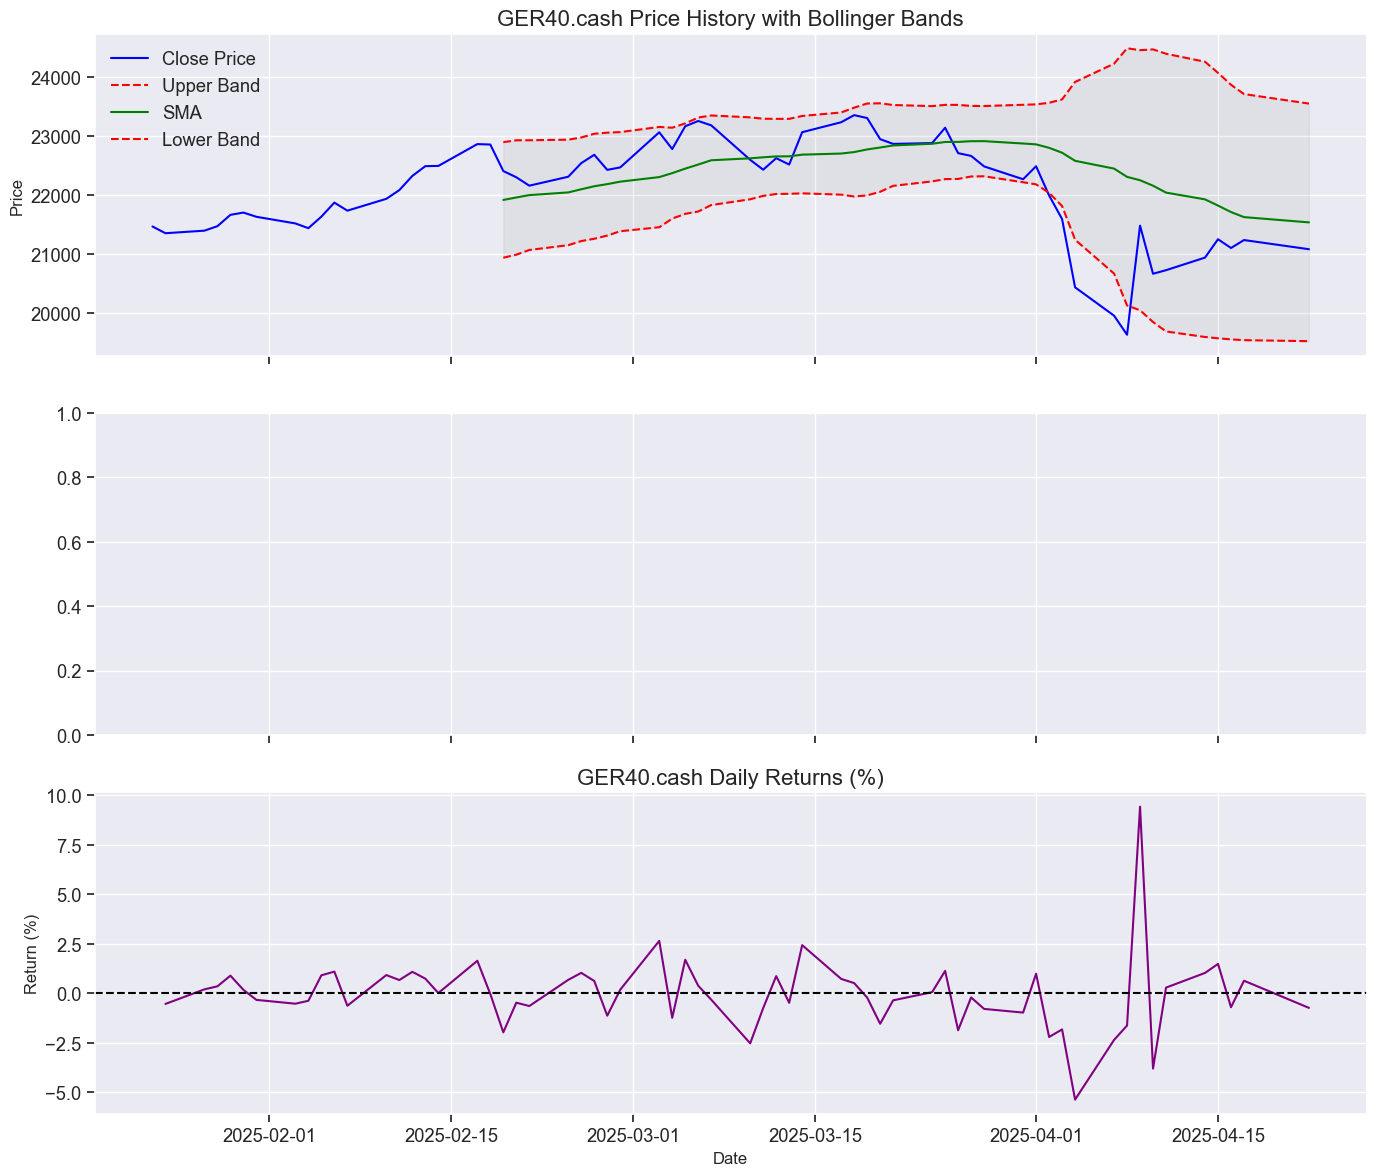

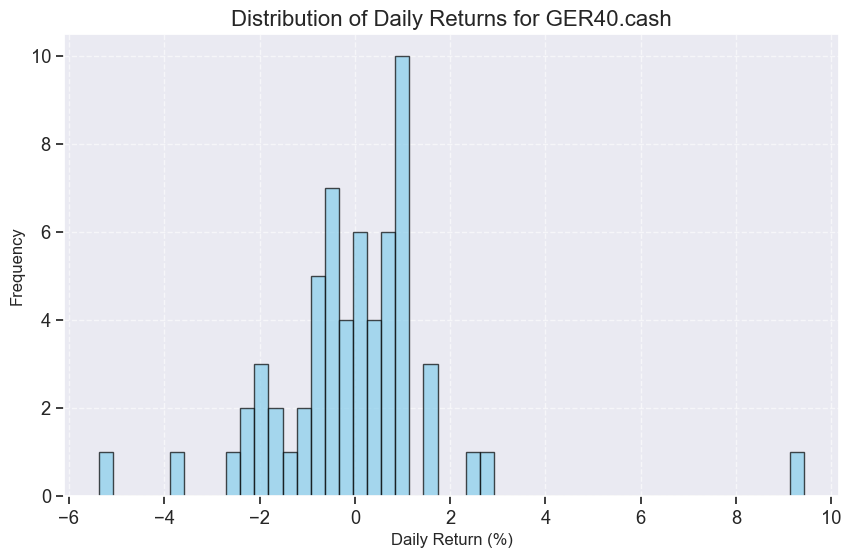

Applying BollongStrategy with parameters:
  window: 50
  std_dev: 2.0
  sl_fixed_percent: 0.02
  tp_fixed_percent: 0.03
  use_trailing_stop: True
  trailing_stop_percent: 0.015
  risk_per_trade: 0.01
  confidence_level: 0.95


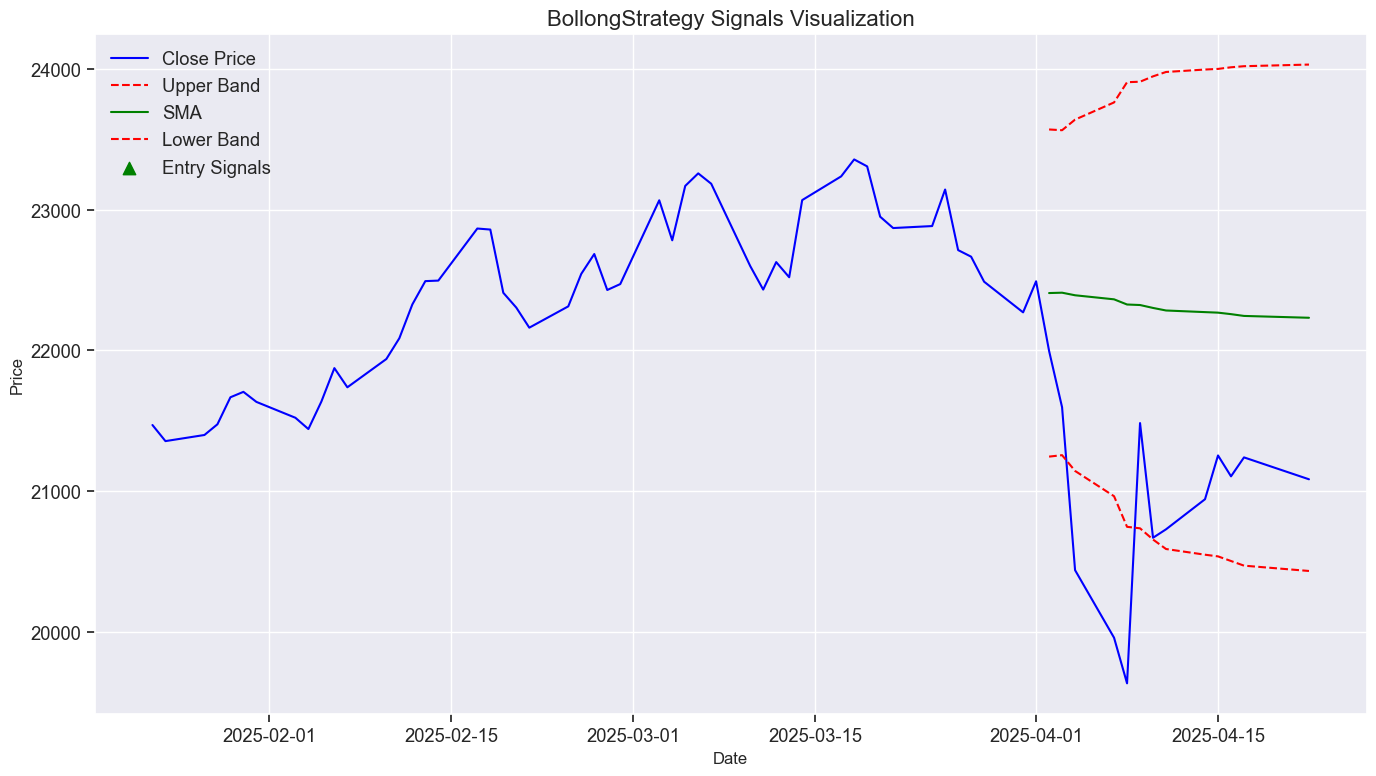


Strategy Statistics:
Total trading days: 62
Total entry signals: 0 (0.00%)
Average stop loss: 2.92%
Average take profit: 7.11%


In [4]:
# 3. STRATEGY VISUALIZATION
# ========================

def visualize_strategy(df: pd.DataFrame, strategy_name: str = "BollongStrategy", params: Dict = None):
    """Visualize strategy signals and performance"""
    if df is None or df.empty:
        print("No data available for strategy visualization")
        return

    if params is None:
        # Default parameters for BollongStrategy
        params = {
            'window': 50,
            'std_dev': 2.0,
            'sl_fixed_percent': 0.02,
            'tp_fixed_percent': 0.03,
            'use_trailing_stop': True,
            'trailing_stop_percent': 0.015,
            'risk_per_trade': 0.01,
            'confidence_level': 0.95
        }

    print(f"Applying {strategy_name} with parameters:")
    for k, v in params.items():
        print(f"  {k}: {v}")

    # Generate strategy signals
    strategy = get_strategy(strategy_name, **params)
    entries, sl_stop, tp_stop = strategy.generate_signals(df)

    # Create a copy to avoid modifying the original DataFrame
    strategy_df = df.copy()
    strategy_df['entries'] = entries
    strategy_df['sl_stop'] = sl_stop
    strategy_df['tp_stop'] = tp_stop

    # Calculate strategy indicators (for BollongStrategy)
    upper_band, sma, lower_band = calculate_bollinger_bands(
        strategy_df['close'], window=params['window'], std_dev=params['std_dev']
    )

    strategy_df['upper_band'] = upper_band
    strategy_df['sma'] = sma
    strategy_df['lower_band'] = lower_band

    # Visualize strategy
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot price and indicators
    ax.plot(strategy_df.index, strategy_df['close'], label='Close Price', color='blue')
    ax.plot(strategy_df.index, strategy_df['upper_band'], label='Upper Band', color='red', linestyle='--')
    ax.plot(strategy_df.index, strategy_df['sma'], label='SMA', color='green', linestyle='-')
    ax.plot(strategy_df.index, strategy_df['lower_band'], label='Lower Band', color='red', linestyle='--')

    # Plot entry signals
    entry_points = strategy_df[strategy_df['entries']].index
    ax.scatter(entry_points, strategy_df.loc[entry_points, 'close'],
               color='green', s=80, marker='^', label='Entry Signals')

    # Calculate stops for visualization
    for idx in entry_points:
        price = strategy_df.loc[idx, 'close']
        sl_pct = strategy_df.loc[idx, 'sl_stop']
        tp_pct = strategy_df.loc[idx, 'tp_stop']

        sl_price = price * (1 - sl_pct)
        tp_price = price * (1 + tp_pct)

        # Draw stop levels
        ax.plot([idx, idx], [price, sl_price], 'r--', alpha=0.5)
        ax.plot([idx, idx], [price, tp_price], 'g--', alpha=0.5)

        # Add points for SL and TP
        ax.scatter(idx, sl_price, color='red', s=50, marker='v')
        ax.scatter(idx, tp_price, color='green', s=50, marker='o')

    ax.set_title(f'{strategy_name} Signals Visualization', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Calculate strategy statistics
    total_signals = entries.sum()
    signal_ratio = total_signals / len(df) * 100

    print(f"\nStrategy Statistics:")
    print(f"Total trading days: {len(df)}")
    print(f"Total entry signals: {total_signals} ({signal_ratio:.2f}%)")
    print(f"Average stop loss: {sl_stop.mean():.2%}")
    print(f"Average take profit: {tp_stop.mean():.2%}")

    return strategy_df

# Main execution in notebook cells
# ================================

# Execute each section as needed
if __name__ == "__main__":
    # 1. Connect to MT5 and get instrument info
    if connect_to_mt5():
        # Get common forex, commodities, and indices
        common_symbols = [
            "EURUSD", "GBPUSD", "USDJPY", "AUDUSD", "USDCAD",
            "XAUUSD", "XAGUSD", "BRENT.CMD", "GER40.cash", "US500.cash"
        ]
        instruments_df = get_instruments_info(common_symbols)
        display(instruments_df)
        visualize_spreads(instruments_df)

        # 2. Analyze historical data for a specific instrument
        symbol = "GER40.cash"  # Example instrument - can be changed
        historical_data = analyze_instrument(symbol, timeframe="D1", days=90)

        # 3. Visualize strategy performance
        if historical_data is not None:
            strategy_params = {
                'window': 50,
                'std_dev': 2.0,
                'sl_fixed_percent': 0.02,
                'tp_fixed_percent': 0.03,
                'use_trailing_stop': True,
                'trailing_stop_percent': 0.015,
                'risk_per_trade': 0.01,
                'confidence_level': 0.95
            }
            strategy_df = visualize_strategy(historical_data,
                                             strategy_name="BollongStrategy",
                                             params=strategy_params)

        # Disconnect from MT5
        mt5.shutdown()

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
import sys
import os
import MetaTrader5 as mt5
from typing import Dict, List, Optional, Tuple
import itertools
from tabulate import tabulate

# CONFIGURATIE
# Pas deze parameters aan naar wens
SYMBOLS_TO_ANALYZE = ["EURUSD", "GBPUSD", "USDJPY", "XAUUSD", "GER40.cash", "US500.cash"]
DEFAULT_SYMBOL = "EURUSD"  # Aangepast naar EURUSD omdat dit vaak meer signalen geeft
DEFAULT_TIMEFRAME = "H1"    # Aangepast naar H1 voor meer datapunten
DEFAULT_DAYS = 90

# BollongStrategy parameters - aangepaste waarden om meer signalen te genereren
STRATEGY_PARAMS = {
    'window': 20,           # Verlaagd van 50 naar 20
    'std_dev': 1.5,         # Verlaagd van 2.0 naar 1.5
    'sl_fixed_percent': 0.01, # Verlaagd
    'tp_fixed_percent': 0.02, # Verlaagd
    'use_trailing_stop': True,
    'trailing_stop_percent': 0.01,
    'risk_per_trade': 0.01,
    'confidence_level': 0.95
}

# Parameter sets om te testen
PARAM_SETS = [
    {'window': 20, 'std_dev': 1.5, 'naam': 'Gevoelig'},
    {'window': 30, 'std_dev': 1.8, 'naam': 'Gemiddeld'},
    {'window': 50, 'std_dev': 2.0, 'naam': 'Conservatief'},
]

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale=1.2)

try:
    from utils.data_utils import fetch_historical_data, TIMEFRAME_MAP
    from utils.indicator_utils import calculate_bollinger_bands
    from strategies import get_strategy
    from strategies.bollong import BollongStrategy
    from config import logger
except ImportError as e:
    print(f"Could not import project modules: {e}")
    print("Make sure you're running this notebook from the project root directory.")

# 1. MT5 INSTRUMENT ANALYSIS
# =========================

def connect_to_mt5() -> bool:
    """Connect to MetaTrader 5"""
    if not mt5.initialize():
        print(f"MT5 initialization failed, error code: {mt5.last_error()}")
        return False

    print(f"Successfully connected to MT5!")
    account_info = mt5.account_info()
    if account_info:
        print(f"Account: {account_info.login} ({account_info.company})")
        print(f"Balance: {account_info.balance} {account_info.currency}")
    return True

def get_instruments_info(symbols: Optional[List[str]] = None) -> pd.DataFrame:
    """Get detailed information about available trading instruments"""
    if not symbols:
        # Get all symbols available in Market Watch
        symbols_info = mt5.symbols_get()
        symbols = [s.name for s in symbols_info]
    else:
        # Ensure all symbols are available in Market Watch
        for symbol in symbols:
            if not mt5.symbol_select(symbol, True):
                print(f"Failed to select {symbol}")

    data = []
    for symbol in symbols:
        symbol_info = mt5.symbol_info(symbol)
        if symbol_info is None:
            print(f"Failed to get info for {symbol}")
            continue

        # Extract trading hours and format them properly
        mon = getattr(symbol_info, 'session_deals_monday', [])
        tue = getattr(symbol_info, 'session_deals_tuesday', [])
        wed = getattr(symbol_info, 'session_deals_wednesday', [])
        thu = getattr(symbol_info, 'session_deals_thursday', [])
        fri = getattr(symbol_info, 'session_deals_friday', [])

        # Format trading hours more readable
        trading_hours = {}
        for day, hours in zip(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], [mon, tue, wed, thu, fri]):
            if hours:
                trading_hours[day] = f"{hours[0][0]}:00 - {hours[0][1]}:00"
            else:
                # Check if there are session_open times available instead
                open_attr = f"session_open_{day.lower()}"
                close_attr = f"session_close_{day.lower()}"
                if hasattr(symbol_info, open_attr) and getattr(symbol_info, open_attr):
                    open_hours = getattr(symbol_info, open_attr)
                    close_hours = getattr(symbol_info, close_attr)
                    if open_hours and close_hours:
                        trading_hours[day] = f"{open_hours[0][0]}:00 - {close_hours[0][1]}:00"
                    else:
                        trading_hours[day] = "Closed"
                else:
                    trading_hours[day] = "24h" if symbol_info.session_deals > 0 else "Closed"

        # Get current spread
        tick = mt5.symbol_info_tick(symbol)
        current_spread = (tick.ask - tick.bid) / symbol_info.point if tick else None

        # Calculate pip value
        contract_size = symbol_info.trade_contract_size
        pip_value = symbol_info.point * contract_size

        data.append({
            'Symbol': symbol_info.name,
            'Description': symbol_info.description,
            'Base Currency': getattr(symbol_info, 'currency_base', ""),
            'Profit Currency': getattr(symbol_info, 'currency_profit', ""),
            'Digits': symbol_info.digits,
            'Point': symbol_info.point,
            'Contract Size': contract_size,
            'Pip Value': pip_value,
            'Min Lot': symbol_info.volume_min,
            'Max Lot': symbol_info.volume_max,
            'Lot Step': symbol_info.volume_step,
            'Current Spread (points)': current_spread,
            'Trading Hours': trading_hours,
            'Trade Mode': symbol_info.trade_mode,
            'Swap Long': symbol_info.swap_long,
            'Swap Short': symbol_info.swap_short,
            'Trade Allowed': symbol_info.trade_mode != 0,
        })

    return pd.DataFrame(data)

def export_instrument_info(df, filename="instrument_info.csv"):
    """Export instrument information to CSV"""
    df.to_csv(filename)
    print(f"Exported instrument information to {filename}")

def visualize_spreads(instruments_df: pd.DataFrame, top_n: int = 20):
    """Visualize spreads for top_n instruments"""
    if 'Current Spread (points)' not in instruments_df.columns:
        print("Spread data not available")
        return

    # Filter out instruments with missing spread data
    spread_df = instruments_df.dropna(subset=['Current Spread (points)'])

    # Sort by spread (lowest first)
    spread_df = spread_df.sort_values('Current Spread (points)').head(top_n)

    # Create plot
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(spread_df)))

    bars = plt.barh(spread_df['Symbol'], spread_df['Current Spread (points)'], color=colors)
    plt.xlabel('Spread (points)')
    plt.ylabel('Symbol')
    plt.title(f'Spreads for Top {top_n} Instruments')
    plt.tight_layout()
    plt.show()

# 2. HISTORICAL DATA ANALYSIS
# ==========================

def analyze_instrument(symbol: str, timeframe: str = "D1", days: int = 90):
    """Analyze historical data for a specific instrument"""
    print(f"Fetching data for {symbol} over the last {days} days (timeframe: {timeframe})")

    # Fetch historical data
    historical_data = fetch_historical_data(
        symbol=symbol,
        timeframe=timeframe,
        days=days
    )

    if historical_data is None or historical_data.empty:
        print(f"No data received for {symbol}")
        return None

    print(f"Successfully retrieved {len(historical_data)} data points")
    print("\nFirst 5 rows of data:")
    display(historical_data.head())

    # Create visualizations
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # 1. Price Chart with Bollinger Bands
    upper_band, sma, lower_band = calculate_bollinger_bands(
        historical_data['close'], window=20, std_dev=2.0
    )

    axes[0].plot(historical_data.index, historical_data['close'], label='Close Price', color='blue')
    axes[0].plot(historical_data.index, upper_band, label='Upper Band', color='red', linestyle='--')
    axes[0].plot(historical_data.index, sma, label='SMA', color='green', linestyle='-')
    axes[0].plot(historical_data.index, lower_band, label='Lower Band', color='red', linestyle='--')
    axes[0].fill_between(historical_data.index, upper_band, lower_band, alpha=0.1, color='gray')
    axes[0].set_title(f'{symbol} Price History with Bollinger Bands', fontsize=16)
    axes[0].set_ylabel('Price', fontsize=12)
    axes[0].legend()
    axes[0].grid(True)

    # 2. Volume chart (if available)
    if 'volume' in historical_data.columns:
        axes[1].bar(historical_data.index, historical_data['volume'], color='green', alpha=0.7)
        axes[1].set_title(f'{symbol} Trading Volume', fontsize=16)
        axes[1].set_ylabel('Volume', fontsize=12)
        axes[1].grid(True)

    # 3. Daily returns
    historical_data['daily_return'] = historical_data['close'].pct_change() * 100
    axes[2].plot(historical_data.index, historical_data['daily_return'], color='purple')
    axes[2].axhline(y=0, color='black', linestyle='--')
    axes[2].set_title(f'{symbol} Daily Returns (%)', fontsize=16)
    axes[2].set_ylabel('Return (%)', fontsize=12)
    axes[2].set_xlabel('Date', fontsize=12)
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # Distribution of returns
    plt.figure(figsize=(10, 6))
    plt.hist(historical_data['daily_return'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Daily Returns for {symbol}', fontsize=16)
    plt.xlabel('Daily Return (%)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    return historical_data

# 3. STRATEGY VISUALIZATION & PERFORMANCE
# ========================================

def calculate_performance(df, entries, sl_stop, tp_stop):
    """Calculate basic performance metrics for strategy"""
    # Create a copy with signals
    perf_df = df.copy()
    perf_df['position'] = 0

    # Initialize position when entry signal occurs
    perf_df.loc[entries, 'position'] = 1

    # Simple position tracking (for visualization purposes)
    # In reality, you'd need more complex logic for exit based on SL/TP
    for i in range(1, len(perf_df)):
        if perf_df['position'].iloc[i-1] == 1 and perf_df['position'].iloc[i] == 0:
            # If we had a position and no new entry signal, continue position
            perf_df['position'].iloc[i] = 1

    # Calculate returns when in position (simplified)
    perf_df['strategy_return'] = perf_df['position'].shift() * perf_df['close'].pct_change()

    # Calculate cumulative returns
    perf_df['cum_return'] = (1 + perf_df['strategy_return'].fillna(0)).cumprod() - 1

    # Calculate metrics
    if entries.sum() > 0:
        total_return = perf_df['cum_return'].iloc[-1] if len(perf_df) > 0 else 0
        drawdown = 1 - (1 + perf_df['cum_return']) / (1 + perf_df['cum_return']).cummax()
        max_dd = drawdown.max()

        return {
            'total_return': total_return,
            'max_drawdown': max_dd,
            'return_to_dd': total_return / max_dd if max_dd > 0 else float('inf'),
            'cumulative_returns': perf_df['cum_return'],
            'perf_df': perf_df
        }
    else:
        return {
            'total_return': 0,
            'max_drawdown': 0,
            'return_to_dd': 0,
            'cumulative_returns': pd.Series(0, index=df.index),
            'perf_df': perf_df
        }

def debug_strategy_conditions(df, strategy_name="BollongStrategy", params=None):
    """Debug why the strategy is not generating signals"""
    if df is None or df.empty:
        print("No data available for strategy debugging")
        return

    if params is None:
        params = STRATEGY_PARAMS

    # Generate strategy signals
    strategy = get_strategy(strategy_name, **params)

    # Get the source code of generate_signals to understand the conditions
    import inspect
    source_code = inspect.getsource(strategy.generate_signals)

    print(f"Strategy Signal Conditions (from {strategy_name}.generate_signals):")
    print("-" * 80)
    for line in source_code.split('\n'):
        if 'entries' in line and ('=' in line or '&=' in line):
            print(f"CONDITION: {line.strip()}")
    print("-" * 80)

    # Calculate indicators used in the strategy
    upper_band, sma, lower_band = calculate_bollinger_bands(
        df['close'], window=params['window'], std_dev=params['std_dev']
    )

    # Create component signals based on conditions in BollongStrategy
    band_width = upper_band - lower_band
    avg_band_width = band_width.rolling(window=20).mean()
    band_width_filter = band_width > avg_band_width * 0.5  # Default threshold

    price_position = (df['close'] - lower_band) / band_width
    price_position_signal = price_position > 0.7  # Default threshold

    # Check bull market (price above long SMA)
    long_sma = df['close'].rolling(window=100).mean()
    bull_market = df['close'] > long_sma

    # Calculate ATR for volatility filter
    def calculate_atr(df, window=14):
        high = df['high']
        low = df['low']
        close = df['close'].shift(1)

        tr1 = high - low
        tr2 = (high - close).abs()
        tr3 = (low - close).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

        atr = tr.rolling(window=window).mean()
        return atr, tr

    atr, _ = calculate_atr(df)
    avg_atr = atr.rolling(window=20).mean()
    volatility_filter = atr < avg_atr * 3.0

    # Count signals at each stage
    total_rows = len(df)
    price_position_count = price_position_signal.sum()
    volatility_filter_count = volatility_filter.sum()
    bull_market_count = bull_market.sum()
    band_width_filter_count = band_width_filter.sum()

    # Combine filters to see the overlap
    combined = price_position_signal & volatility_filter & bull_market & band_width_filter
    combined_count = combined.sum()

    print(f"Signal Counts by Condition (out of {total_rows} bars):")
    print(f"- Price position > 0.7: {price_position_count} ({price_position_count/total_rows:.1%})")
    print(f"- Volatility filter (ATR < avg*3): {volatility_filter_count} ({volatility_filter_count/total_rows:.1%})")
    print(f"- Bull market (price > long MA): {bull_market_count} ({bull_market_count/total_rows:.1%})")
    print(f"- Band width filter: {band_width_filter_count} ({band_width_filter_count/total_rows:.1%})")
    print(f"- All conditions combined: {combined_count} ({combined_count/total_rows:.1%})")

    # Visualize the conditions
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # Price and bands
    axes[0].plot(df.index, df['close'], label='Close', color='blue')
    axes[0].plot(df.index, upper_band, label='Upper Band', color='red', linestyle='--')
    axes[0].plot(df.index, sma, label='SMA', color='green')
    axes[0].plot(df.index, lower_band, label='Lower Band', color='red', linestyle='--')
    axes[0].plot(df.index, long_sma, label='Long SMA (100)', color='purple', linestyle='-.')

    # Highlight where price position > 0.7 and bull market
    price_pos_mask = price_position_signal & bull_market
    axes[0].scatter(df.index[price_pos_mask],
                   df.loc[price_pos_mask, 'close'],
                   color='green', marker='^', s=80,
                   label='Price Position & Bull Market')

    axes[0].set_title(f'Price Position and Bull Market Filter', fontsize=14)
    axes[0].legend()

    # Volatility filter
    axes[1].plot(df.index, atr, label='ATR', color='orange')
    axes[1].plot(df.index, avg_atr * 3.0, label='ATR Threshold (3x Avg)', color='red', linestyle='--')
    axes[1].set_title('Volatility Filter (ATR)', fontsize=14)
    axes[1].legend()

    # Band width
    axes[2].plot(df.index, band_width, label='Band Width', color='purple')
    axes[2].plot(df.index, avg_band_width * 0.5, label='Band Width Threshold', color='blue', linestyle='--')
    axes[2].set_title('Band Width Filter', fontsize=14)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return {
        'price_position': price_position,
        'price_position_signal': price_position_signal,
        'volatility_filter': volatility_filter,
        'bull_market': bull_market,
        'band_width_filter': band_width_filter,
        'combined': combined
    }

def visualize_strategy(df: pd.DataFrame, strategy_name: str = "BollongStrategy", params: Dict = None):
    """Visualize strategy signals and performance"""
    if df is None or df.empty:
        print("No data available for strategy visualization")
        return

    if params is None:
        params = STRATEGY_PARAMS

    print(f"Applying {strategy_name} with parameters:")
    for k, v in params.items():
        print(f"  {k}: {v}")

    # Generate strategy signals
    strategy = get_strategy(strategy_name, **params)
    entries, sl_stop, tp_stop = strategy.generate_signals(df)

    # Create a copy to avoid modifying the original DataFrame
    strategy_df = df.copy()
    strategy_df['entries'] = entries
    strategy_df['sl_stop'] = sl_stop
    strategy_df['tp_stop'] = tp_stop

    # Calculate strategy indicators (for BollongStrategy)
    upper_band, sma, lower_band = calculate_bollinger_bands(
        strategy_df['close'], window=params['window'], std_dev=params['std_dev']
    )

    strategy_df['upper_band'] = upper_band
    strategy_df['sma'] = sma
    strategy_df['lower_band'] = lower_band

    # Visualize strategy
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot price and indicators
    ax.plot(strategy_df.index, strategy_df['close'], label='Close Price', color='blue')
    ax.plot(strategy_df.index, strategy_df['upper_band'], label='Upper Band', color='red', linestyle='--')
    ax.plot(strategy_df.index, strategy_df['sma'], label='SMA', color='green', linestyle='-')
    ax.plot(strategy_df.index, strategy_df['lower_band'], label='Lower Band', color='red', linestyle='--')

    # Plot entry signals
    entry_points = strategy_df[strategy_df['entries']].index
    if len(entry_points) > 0:
        ax.scatter(entry_points, strategy_df.loc[entry_points, 'close'],
                  color='green', s=80, marker='^', label='Entry Signals')

        # Calculate stops for visualization
        for idx in entry_points:
            price = strategy_df.loc[idx, 'close']
            sl_pct = strategy_df.loc[idx, 'sl_stop']
            tp_pct = strategy_df.loc[idx, 'tp_stop']

            sl_price = price * (1 - sl_pct)
            tp_price = price * (1 + tp_pct)

            # Draw stop levels
            ax.plot([idx, idx], [price, sl_price], 'r--', alpha=0.5)
            ax.plot([idx, idx], [price, tp_price], 'g--', alpha=0.5)

            # Add points for SL and TP
            ax.scatter(idx, sl_price, color='red', s=50, marker='v')
            ax.scatter(idx, tp_price, color='green', s=50, marker='o')

    ax.set_title(f'{strategy_name} Signals Visualization', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Calculate strategy statistics
    total_signals = entries.sum()
    signal_ratio = total_signals / len(df) * 100

    print(f"\nStrategy Statistics:")
    print(f"Total trading days: {len(df)}")
    print(f"Total entry signals: {total_signals} ({signal_ratio:.2f}%)")
    print(f"Average stop loss: {sl_stop.mean():.2%}")
    print(f"Average take profit: {tp_stop.mean():.2%}")

    # Calculate and display performance metrics if we have signals
    if total_signals > 0:
        performance = calculate_performance(df, entries, sl_stop, tp_stop)

        plt.figure(figsize=(14, 6))
        plt.plot(performance['cumulative_returns'].index, performance['cumulative_returns'] * 100)
        plt.title(f'{strategy_name} Cumulative Return (%)')
        plt.xlabel('Date')
        plt.ylabel('Return (%)')
        plt.grid(True)
        plt.show()

        print(f"\nPerformance Metrics:")
        print(f"Total Return: {performance['total_return']:.2%}")
        print(f"Max Drawdown: {performance['max_drawdown']:.2%}")
        print(f"Return/Drawdown Ratio: {performance['return_to_dd']:.2f}")
    else:
        print("\nNo signals generated - can't calculate performance metrics")
        # If no signals were generated, run the debugging function
        debug_conditions = debug_strategy_conditions(df, strategy_name, params)

    return strategy_df

def test_multiple_param_sets(df: pd.DataFrame, param_sets: List[Dict], strategy_name: str = "BollongStrategy"):
    """Test multiple parameter sets and compare results"""
    if df is None or df.empty:
        print("No data available for testing")
        return

    results = []

    for i, params in enumerate(param_sets):
        # Create a complete parameter set by updating STRATEGY_PARAMS with the current set
        complete_params = STRATEGY_PARAMS.copy()
        complete_params.update(params)

        set_name = params.get('naam', f"Set {i+1}")
        print(f"\n--- Testing Parameter Set: {set_name} ---")

        # Generate strategy signals
        strategy = get_strategy(strategy_name, **complete_params)
        entries, sl_stop, tp_stop = strategy.generate_signals(df)

        total_signals = entries.sum()
        signal_ratio = total_signals / len(df) * 100

        if total_signals > 0:
            performance = calculate_performance(df, entries, sl_stop, tp_stop)

            results.append({
                'Set': set_name,
                'Window': params.get('window', STRATEGY_PARAMS['window']),
                'StdDev': params.get('std_dev', STRATEGY_PARAMS['std_dev']),
                'Signals': total_signals,
                'Signal %': f"{signal_ratio:.2f}%",
                'Return': f"{performance['total_return']:.2%}",
                'Max DD': f"{performance['max_drawdown']:.2%}",
                'Ret/DD': f"{performance['return_to_dd']:.2f}",
                'Avg SL': f"{sl_stop.mean():.2%}",
                'Avg TP': f"{tp_stop.mean():.2%}",
                'entries': entries,
                'sl_stop': sl_stop,
                'tp_stop': tp_stop,
                'performance': performance
            })
        else:
            results.append({
                'Set': set_name,
                'Window': params.get('window', STRATEGY_PARAMS['window']),
                'StdDev': params.get('std_dev', STRATEGY_PARAMS['std_dev']),
                'Signals': 0,
                'Signal %': "0.00%",
                'Return': "0.00%",
                'Max DD': "0.00%",
                'Ret/DD': "0.00",
                'Avg SL': f"{sl_stop.mean():.2%}",
                'Avg TP': f"{tp_stop.mean():.2%}",
                'entries': entries,
                'sl_stop': sl_stop,
                'tp_stop': tp_stop,
                'performance': None
            })

    # Display results table
    if results:
        # Convert to dataframe for tabular display
        display_cols = ['Set', 'Window', 'StdDev', 'Signals', 'Signal %', 'Return', 'Max DD', 'Ret/DD', 'Avg SL', 'Avg TP']
        results_df = pd.DataFrame([{k: v for k, v in r.items() if k in display_cols} for r in results])
        display(results_df)

        # Visualize cumulative returns for sets with signals
        plt.figure(figsize=(14, 6))

        for result in results:
            if result['Signals'] > 0 and result['performance'] is not None:
                plt.plot(result['performance']['cumulative_returns'].index,
                        result['performance']['cumulative_returns'] * 100,
                        label=f"{result['Set']} (Win:{result['Window']}, Std:{result['StdDev']})")

        if any(r['Signals'] > 0 for r in results):
            plt.title(f'Cumulative Returns Comparison')
            plt.xlabel('Date')
            plt.ylabel('Return (%)')
            plt.legend()
            plt.grid(True)
            plt.show()

        # Find and return the best parameter set
        best_result = None
        for result in results:
            if result['Signals'] > 0:
                if best_result is None or float(result['Return'].rstrip('%')) > float(best_result['Return'].rstrip('%')):
                    best_result = result

        if best_result:
            print(f"\nBest parameter set: {best_result['Set']} with {best_result['Return']} return")
            return best_result

    print("\nNone of the parameter sets generated profitable signals")
    return None

def test_parameter_grid(df: pd.DataFrame, strategy_name: str = "BollongStrategy"):
    """Test a grid of window and std_dev values to find optimal parameters"""
    if df is None or df.empty:
        print("No data available for parameter grid search")
        return

    # Create a grid of parameters to test
    windows = [10, 15, 20, 30, 40, 50]
    std_devs = [1.0, 1.2, 1.5, 1.8, 2.0, 2.5]

    print(f"Testing parameter grid: {len(windows)}x{len(std_devs)} = {len(windows)*len(std_devs)} combinations")

    results = []
    base_params = STRATEGY_PARAMS.copy()

    for window, std_dev in itertools.product(windows, std_devs):
        params = base_params.copy()
        params['window'] = window
        params['std_dev'] = std_dev

        # Generate signals
        strategy = get_strategy(strategy_name, **params)
        entries, sl_stop, tp_stop = strategy.generate_signals(df)

        total_signals = entries.sum()
        if total_signals > 0:
            performance = calculate_performance(df, entries, sl_stop, tp_stop)

            results.append({
                'window': window,
                'std_dev': std_dev,
                'signals': total_signals,
                'signal_pct': total_signals / len(df) * 100,
                'return': performance['total_return'] * 100,  # Convert to percentage
                'max_dd': performance['max_drawdown'] * 100,  # Convert to percentage
                'ret_dd': performance['return_to_dd']
            })

            print(f"Window: {window}, StdDev: {std_dev} - Signals: {total_signals}, Return: {performance['total_return']:.2%}")
        else:
            results.append({
                'window': window,
                'std_dev': std_dev,
                'signals': 0,
                'signal_pct': 0,
                'return': 0,
                'max_dd': 0,
                'ret_dd': 0
            })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    if len(results_df[results_df['signals'] > 0]) > 0:
        # Visualize results
        plt.figure(figsize=(10, 8))
        pivot_table = results_df.pivot_table(index='window', columns='std_dev', values='return')
        sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', center=0, fmt='.1f')
        plt.title('Returns (%) by Window and StdDev')
        plt.ylabel('Window Size')
        plt.xlabel('Standard Deviation')
        plt.tight_layout()
        plt.show()

        # Find best parameters
        best_result = results_df.loc[results_df['return'].idxmax()]

        print(f"\nBest Parameters:")
        print(f"Window: {best_result['window']}")
        print(f"StdDev: {best_result['std_dev']}")
        print(f"Return: {best_result['return']:.2f}%")
        print(f"Max Drawdown: {best_result['max_dd']:.2f}%")
        print(f"Return/Drawdown: {best_result['ret_dd']:.2f}")
        print(f"Signals: {best_result['signals']} ({best_result['signal_pct']:.2f}%)")

        # Return the best parameters
        return {
            'window': int(best_result['window']),
            'std_dev': float(best_result['std_dev'])
        }
    else:
        print("No parameter combination generated signals")
        return None